<h1 style="text-align: center;">CAE Clustering</h1>

# Setup

## Importing libraries

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from keras.models import Sequential, Model
import tensorflow as tf
from tensorflow.keras.utils import plot_model #from keras.utils.vis_utils import plot_model
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
from scipy.optimize import linear_sum_assignment as linear_assignment
from keras.callbacks import CSVLogger

import os
#os.chdir('/mnt/f/etfs/Cluster2')

# Printing current/ working directories
current_dir = os.getcwd()
print("Notebooks directory:", current_dir)

# Obtenir le répertoire parent
parent_dir = os.path.dirname(current_dir)
print("Local working directory:", parent_dir)

data_dir = parent_dir+"/data/"
print("Data directory:", data_dir)
# os.chdir('/mnt/f/etfs/Cluster1')


Notebooks directory: /Users/omar/Documents/WQU-Capstone/data
Local working directory: /Users/omar/Documents/WQU-Capstone
Data directory: /Users/omar/Documents/WQU-Capstone/data/


# Data Preprocessing

## Data loading

In [8]:
sample_yf_pkl = data_dir+"sample_yf_data.pkl"
index_dict = pd.read_pickle(sample_yf_pkl)
index_dict

{'VXUS':                Close      High       Low      Open    Volume       RSI  \
 Date                                                                     
 2018-03-13  0.449782  0.440483  0.458006  0.457832  0.024600  0.426933   
 2018-03-14  0.453477  0.439978  0.459483  0.459576  0.011080  0.444614   
 2018-03-15  0.451506  0.436440  0.459729  0.452602  0.015261  0.434411   
 2018-03-16  0.448797  0.430881  0.458745  0.447621  0.007255  0.419834   
 2018-03-19  0.436485  0.421532  0.441513  0.441644  0.024682  0.356471   
 ...              ...       ...       ...       ...       ...       ...   
 2025-03-25  0.984793  0.980655  0.992710  0.991379  0.242585  0.539634   
 2025-03-26  0.964618  0.970932  0.972543  0.980868  0.190105  0.454309   
 2025-03-27  0.968897  0.965913  0.972543  0.966956  0.135959  0.470113   
 2025-03-28  0.946277  0.951171  0.953598  0.964173  0.252463  0.382971   
 2025-03-31  0.933744  0.927647  0.925181  0.925838  0.244050  0.340206   
 
               

In [6]:
print(f"Number of indices: {len(index_dict)}")

Number of indices: 44


## Data cleaning

In [7]:
def clean_index(index_dict):
  """
  Removes entries from index_dict where the associated DataFrame has zero rows.
  """
  index_keys = list(index_dict.keys())
  for index in index_keys:
    if index_dict[index].shape[0] == 0:
      del index_dict[index]
  return index_dict

clean_index(index_dict)

{'VXUS':                Close      High       Low      Open    Volume       RSI  \
 Date                                                                     
 2018-03-13  0.449782  0.440483  0.458006  0.457832  0.024600  0.426933   
 2018-03-14  0.453477  0.439978  0.459483  0.459576  0.011080  0.444614   
 2018-03-15  0.451506  0.436440  0.459729  0.452602  0.015261  0.434411   
 2018-03-16  0.448797  0.430881  0.458745  0.447621  0.007255  0.419834   
 2018-03-19  0.436485  0.421532  0.441513  0.441644  0.024682  0.356471   
 ...              ...       ...       ...       ...       ...       ...   
 2025-03-25  0.984793  0.980655  0.992710  0.991379  0.242585  0.539634   
 2025-03-26  0.964618  0.970932  0.972543  0.980868  0.190105  0.454309   
 2025-03-27  0.968897  0.965913  0.972543  0.966956  0.135959  0.470113   
 2025-03-28  0.946277  0.951171  0.953598  0.964173  0.252463  0.382971   
 2025-03-31  0.933744  0.927647  0.925181  0.925838  0.244050  0.340206   
 
               

## Shape Analysis

In [9]:
def check_shapes(index_dict):
    '''
    Function to check that all indices have the same shape.
    '''
    # Extract shapes as list
    shapes = [str(index_dict[key].shape) for key in index_dict]
    
    # Counting the occurrences of each shape
    shape_counts = pd.Series(shapes).value_counts().reset_index()
    shape_counts.columns = ["Shape", "Indices Count"]
    
    print(shape_counts)
    if shape_counts.shape[0] > 1:
        print(f"\n❌ Not all indices have the same shape.")
    else:
        print(f"\n✅ All {len(index_dict)} indices have the same shape.")

check_shapes(index_dict)

        Shape  Indices Count
0  (1773, 63)             44

✅ All 44 indices have the same shape.


In [10]:
indices = list(index_dict.keys())

## Data flattening

In [11]:
reformed_dict = {}
for outerKey, innerDict in index_dict.items():
    for innerKey, values in innerDict.items():
        reformed_dict[(outerKey,
                       innerKey)] = values

In [12]:
data = pd.DataFrame(reformed_dict)
data.shape

(1773, 2772)

## Missing values

In [13]:
def check_missing_values(data):
    """
    Checks for missing values in the DataFrame.
    """
    missing_values = data.isna().sum().sum()
    if missing_values > 0:
        print(f"❌ There are {missing_values} missing values in the DataFrame.")
    else:
        print("✅ No missing values found in the DataFrame.")

check_missing_values(data)

✅ No missing values found in the DataFrame.


# Clustering Preparation

## Clustering Evaluation Metrics

In [14]:
nmi = normalized_mutual_info_score
ari = adjusted_rand_score

def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

## Clustering Parameters

In [15]:
args = {
        'n_clusters' : 10,
        'batch_size' : 32,
        'epochs' : 1000,
        'save_dir' : 'results/temp'
}
print(args)

{'n_clusters': 10, 'batch_size': 32, 'epochs': 1000, 'save_dir': 'results/temp'}


## Results directory

In [16]:
if not os.path.exists(args['save_dir']):
  os.makedirs(args['save_dir'])

## Space Dimensions

In [17]:
n_timesteps = data.shape[0]
n_features = data[indices[0]].shape[1]
n_indices = int(data.shape[1]/data[indices[0]].shape[1])
print(f'n_timesteps : {n_timesteps}, n_features : {n_features}, n_indices : {n_indices}')

n_timesteps : 1773, n_features : 63, n_indices : 44


## Reshaping Data for Model Input

In [18]:
x = data.values
x = x.reshape(-1, n_timesteps, n_features,1).astype('float32')

In [19]:
x.shape

(44, 1773, 63, 1)

/var/folders/9l/11hrvfp943dgcqnmsc9cqgdh0000gn/T/ipykernel_24780/164601145.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for the colorbar


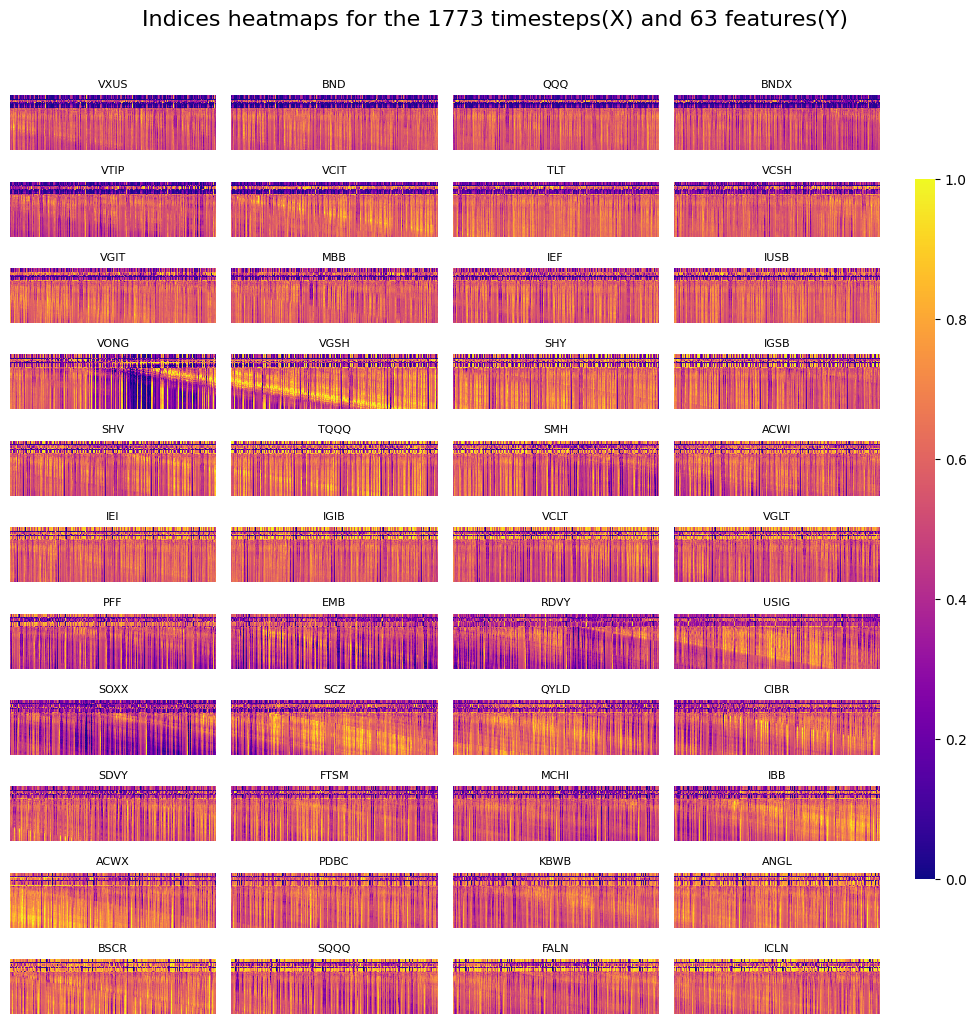

In [38]:
import seaborn as sns

# Visualize all 44 indices using heatmaps
fig, axes = plt.subplots(11, 4, figsize=(10, 10))  # Create a grid of subplots
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Create a colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

for i in range(44):
    sns.heatmap(x[i, :, :, 0].T, cmap="plasma", ax=axes[i], cbar=(i == 0), cbar_ax=None if i else cbar_ax)  # Transpose to have timesteps on x-axis
    axes[i].set_title(f"{indices[i]}", fontsize=8)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.suptitle("Indices heatmaps for the 1773 timesteps(X) and 63 features(Y)", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for the colorbar
plt.show()


In [39]:
print(data.columns.get_level_values(1).unique())

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'MFI', 'ADX', 'OBV',
       'ATR', 'Boll_upper', 'Boll_mid', 'Boll_lower', 'EMA', 'MACD', 'LR_1',
       'LR_2', 'LR_3', 'LR_4', 'LR_5', 'LR_6', 'LR_7', 'LR_8', 'LR_9', 'LR_10',
       'LR_11', 'LR_12', 'LR_13', 'LR_14', 'LR_15', 'LR_16', 'LR_17', 'LR_18',
       'LR_19', 'LR_20', 'LR_21', 'LR_22', 'LR_23', 'LR_24', 'LR_25', 'LR_26',
       'LR_27', 'LR_28', 'LR_29', 'LR_30', 'LR_31', 'LR_32', 'LR_33', 'LR_34',
       'LR_35', 'LR_36', 'LR_37', 'LR_38', 'LR_39', 'LR_40', 'LR_41', 'LR_42',
       'LR_43', 'LR_44', 'LR_45', 'LR_46', 'LR_47', 'LR_48'],
      dtype='object')


In [40]:
data

VXUS                                                    \
               Close      High       Low      Open    Volume       RSI   
Date                                                                     
2018-03-13  0.449782  0.440483  0.458006  0.457832  0.024600  0.426933   
2018-03-14  0.453477  0.439978  0.459483  0.459576  0.011080  0.444614   
2018-03-15  0.451506  0.436440  0.459729  0.452602  0.015261  0.434411   
2018-03-16  0.448797  0.430881  0.458745  0.447621  0.007255  0.419834   
2018-03-19  0.436485  0.421532  0.441513  0.441644  0.024682  0.356471   
...              ...       ...       ...       ...       ...       ...   
2025-03-25  0.984793  0.980655  0.992710  0.991379  0.242585  0.539634   
2025-03-26  0.964618  0.970932  0.972543  0.980868  0.190105  0.454309   
2025-03-27  0.968897  0.965913  0.972543  0.966956  0.135959  0.470113   
2025-03-28  0.946277  0.951171  0.953598  0.964173  0.252463  0.382971   
2025-03-31  0.933744  0.927647  0.925181  0.925838  0.244050  0.340206   

                                                    ...      ICLN            \
                 MFI       ADX       OBV       ATR  ...     LR_39     LR_40   
Date                                                ...                       
2018-03-13  0.484107  0.484107  0.235719  0.190792  ...  0.458906  0.462832   
2018-03-14  0.467146  0.467146  0.237442  0.185640  ...  0.454082  0.470117   
2018-03-15  0.389540  0.389540  0.235482  0.175418  ...  0.463776  0.464072   
2018-03-16  0.303153  0.303153  0.233975  0.159400  ...  0.452800  0.464001   
2018-03-19  0.323788  0.323788  0.231481  0.163741  ...  0.458912  0.467685   
...              ...       ...       ...       ...  ...       ...       ...   
2025-03-25  0.498077  0.498077  0.663802  0.291637  ...  0.527644  0.529055   
2025-03-26  0.570090  0.570090  0.651931  0.293543  ...  0.497868  0.521320   
2025-03-27  0.489128  0.489128  0.660733  0.280013  ...  0.477212  0.506641   
2025-03-28  0.497655  0.497655  0.645328  0.287250  ...  0.481314  0.485985   
2025-03-31  0.502163  0.502163  0.630400  0.302521  ...  0.483549  0.478891   

                                                                        \
               LR_41     LR_42     LR_43     LR_44     LR_45     LR_46   
Date                                                                     
2018-03-13  0.458320  0.472727  0.440430  0.444683  0.450849  0.440810   
2018-03-14  0.464465  0.452017  0.444981  0.449243  0.436946  0.439608   
2018-03-15  0.470614  0.456861  0.424605  0.452669  0.440385  0.424717   
2018-03-16  0.454582  0.453156  0.420023  0.423125  0.434674  0.419060   
2018-03-19  0.469375  0.452005  0.430214  0.432203  0.418720  0.427010   
...              ...       ...       ...       ...       ...       ...   
2025-03-25  0.525955  0.514247  0.495949  0.474405  0.453957  0.444217   
2025-03-26  0.513832  0.501228  0.467251  0.488570  0.450383  0.426414   
2025-03-27  0.521297  0.504372  0.469194  0.473869  0.478776  0.436885   
2025-03-28  0.506413  0.511741  0.472115  0.475817  0.463998  0.464982   
2025-03-31  0.474116  0.485842  0.468550  0.468304  0.455460  0.439970   

                                
               LR_47     LR_48  
Date                            
2018-03-13  0.435287  0.424900  
2018-03-14  0.445718  0.429407  
2018-03-15  0.443360  0.438505  
2018-03-16  0.419170  0.427231  
2018-03-19  0.427194  0.416990  
...              ...       ...  
2025-03-25  0.449759  0.453675  
2025-03-26  0.432728  0.427487  
2025-03-27  0.428894  0.424662  
2025-03-28  0.439469  0.420906  
2025-03-31  0.457356  0.420987  

[1773 rows x 2772 columns]

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1773 entries, 2018-03-13 to 2025-03-31
Columns: 2772 entries, ('VXUS', 'Close') to ('ICLN', 'LR_48')
dtypes: float32(2332), float64(440)
memory usage: 21.7 MB


In [42]:
data['ICLN'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1773 entries, 2018-03-13 to 2025-03-31
Data columns (total 63 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close       1773 non-null   float32
 1   High        1773 non-null   float32
 2   Low         1773 non-null   float32
 3   Open        1773 non-null   float32
 4   Volume      1773 non-null   float32
 5   RSI         1773 non-null   float64
 6   MFI         1773 non-null   float64
 7   ADX         1773 non-null   float64
 8   OBV         1773 non-null   float64
 9   ATR         1773 non-null   float64
 10  Boll_upper  1773 non-null   float64
 11  Boll_mid    1773 non-null   float64
 12  Boll_lower  1773 non-null   float64
 13  EMA         1773 non-null   float64
 14  MACD        1773 non-null   float64
 15  LR_1        1773 non-null   float32
 16  LR_2        1773 non-null   float32
 17  LR_3        1773 non-null   float32
 18  LR_4        1773 non-null   float32
 19  LR_5     

# CAE Model

## Enconding

In [43]:
model = Sequential()
input_shape = x.shape[1:]
filters = [32, 64, 128, 10]

#encoding layer
if input_shape[0] % 8 == 0:
    pad3 = 'same'
else:
    pad3 = 'valid'
model.add(Conv2D(filters[0], 5, strides=1, padding='same', activation='relu', name='conv1', input_shape=input_shape))

model.add(Conv2D(filters[1], 5, strides=1, padding='same', activation='relu', name='conv2'))

model.add(Conv2D(filters[2], 3, strides=1, padding=pad3, activation='relu', name='conv3'))

model.add(Flatten(name = 'flatten'))
model.add(Dense(units=filters[3], name='embedding'))

prev_layer_output = model.get_layer(index=model.layers.index(model.get_layer('flatten'))-1).output
flattened_size = np.prod(prev_layer_output.shape[1:])
model.add(Dense(units=int(flattened_size), activation='relu')) #model.add(Dense(units = model.get_layer(name='flatten').output_shape[-1], activation = 'relu'))

model.summary()

/Users/omar/Documents/WQU-Capstone/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 1773, 63, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 1773, 63, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 1771, 61, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13827968)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 10)             │   138,279,690 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 13827968)       │   152,107,648 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,513,290 (1.08 GB)

 Trainable params: 290,513,290 (1.08 GB)

 Non-trainable params: 0 (0.00 B)

## Decoding

In [44]:
#decoding layers

model.add(Reshape((input_shape[0]-2, input_shape[1] - 2, filters[2])))

model.add(Conv2DTranspose(filters[1], 3, strides=1, padding=pad3, activation='relu', name='deconv3'))

model.add(Conv2DTranspose(filters[0], 5, strides=1, padding='same', activation='relu', name='deconv2'))

model.add(Conv2DTranspose(input_shape[2], 5, strides=1, padding='same', name='deconv1'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 1773, 63, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 1773, 63, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 1771, 61, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13827968)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 10)             │   138,279,690 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 13827968)       │   152,107,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1771, 61, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv3 (Conv2DTranspose)       │ (None, 1773, 63, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv2 (Conv2DTranspose)       │ (None, 1773, 63, 32)   │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv1 (Conv2DTranspose)       │ (None, 1773, 63, 1)    │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,639,115 (1.08 GB)

 Trainable params: 290,639,115 (1.08 GB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# define the model
plot_model(model, to_file=args['save_dir'] + '/%s-pretrain-model.png' % 'data', show_shapes=True)
model.summary()

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 1773, 63, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 1773, 63, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 1771, 61, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13827968)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 10)             │   138,279,690 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 13827968)       │   152,107,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1771, 61, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv3 (Conv2DTranspose)       │ (None, 1773, 63, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv2 (Conv2DTranspose)       │ (None, 1773, 63, 32)   │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv1 (Conv2DTranspose)       │ (None, 1773, 63, 1)    │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,639,115 (1.08 GB)

 Trainable params: 290,639,115 (1.08 GB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# compile the model and callbacks
optimizer = 'adam'
model.compile(optimizer=optimizer, loss='mse')
csv_logger = CSVLogger(args['save_dir'] + '/%s-pretrain-log.csv' % 'data')

## Model training

In [47]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='loss', save_best_only=True)

# begin training
from time import time
t0 = time()

history = model.fit(
    x, x,
    batch_size=args['batch_size'],
    epochs=16,  # args['epochs'],
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, csv_logger]
)
print('Training time: ', time() - t0)
model.save(f"{args['save_dir']}/data-pretrain-model-{args['epochs']}.keras")

Epoch 1/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 62s 18s/step - loss: 0.3050
Epoch 2/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 9s/step - loss: 179.0323
Epoch 3/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 10s/step - loss: 0.5885
Epoch 4/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 16s/step - loss: 0.5782
Epoch 5/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 14s/step - loss: 0.4611
Epoch 6/16
2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 14s/step - loss: 0.3721
Training time:  313.91068625450134


## Training loss

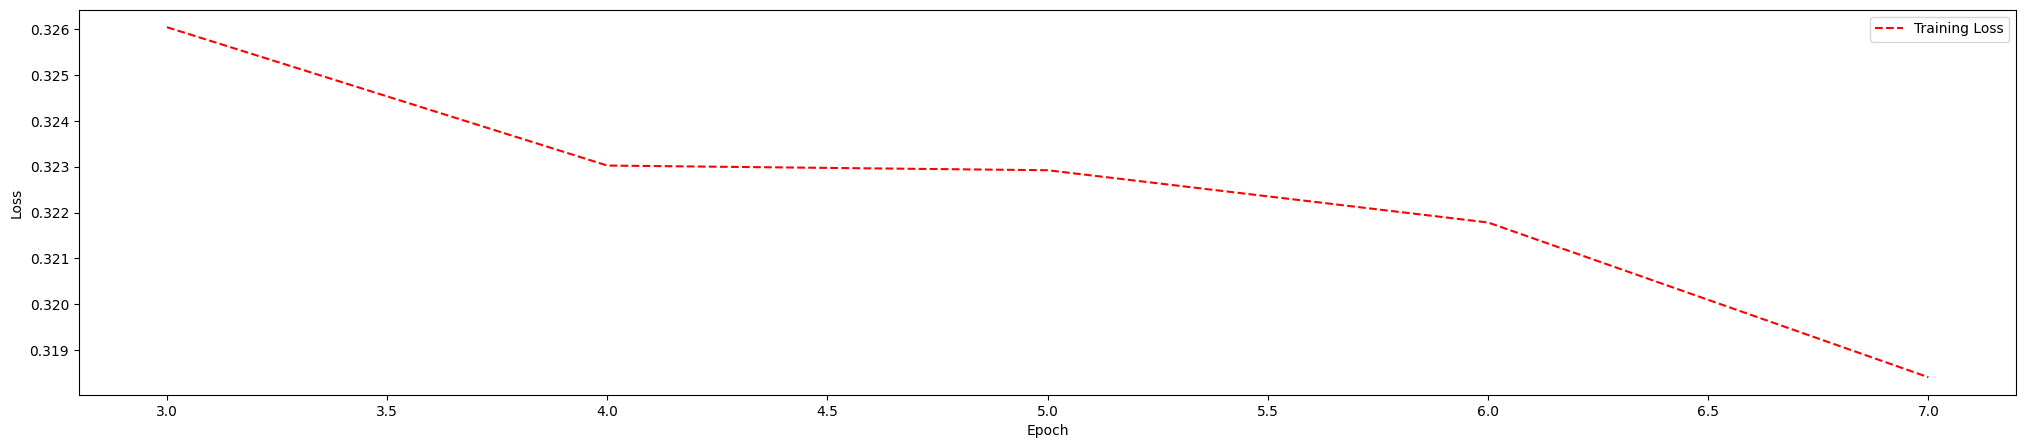

In [65]:
training_loss = history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.figure(figsize = (25,5))
plt.plot(epoch_count[2:], training_loss[2:], "r--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training Loss"])
plt.show()

In [66]:
model

<Sequential name=sequential, built=True>

## Latent Risk Factor Extraction

In [68]:
# features = model.predict(x[0:4])
# for i in range(4, len(x), 4): # splitting the predictions due to GPU memory limitations
#     print(i, i+4)
#     features_4 = model.predict(x[i:i+4])
#     features = np.concatenate((features, features_4), axis=0)
# features

# Predict all features at once as there is no need to split anymore
features = model.predict(x)
features

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


array([[[[-0.00326433],
         [ 0.08805668],
         [ 0.08869465],
         ...,
         [ 0.5249473 ],
         [ 0.03182938],
         [ 0.00292841]],

        [[-0.00326433],
         [ 0.02622276],
         [-0.07872711],
         ...,
         [ 0.6348835 ],
         [ 0.09745868],
         [-0.0635367 ]],

        [[-0.00326433],
         [ 0.06773676],
         [-0.04218721],
         ...,
         [ 0.5082723 ],
         [ 0.20228475],
         [-0.03401329]],

        ...,

        [[ 0.06123564],
         [ 0.04448307],
         [ 0.03593506],
         ...,
         [ 0.09914022],
         [ 0.09220212],
         [ 0.09278126]],

        [[ 0.06877287],
         [ 0.10253739],
         [ 0.13725504],
         ...,
         [ 0.3315229 ],
         [-0.2461187 ],
         [ 0.27501294]],

        [[ 0.03915926],
         [-0.08932843],
         [ 0.07902727],
         ...,
         [ 0.29605922],
         [-0.19855168],
         [ 0.09056349]]],


       [[[-0.00326433],


In [69]:
features.shape

(44, 1773, 63, 1)

# Agglomerative Clustering

In [70]:
from sklearn.cluster import AgglomerativeClustering
Agg_Clustering = AgglomerativeClustering(n_clusters = 10)
features = np.reshape(features, newshape = (features.shape[0], -1))
pred = Agg_Clustering.fit_predict(features)

In [71]:
pred

array([1, 6, 6, 4, 1, 0, 0, 0, 2, 0, 0, 2, 0, 3, 3, 8, 8, 3, 2, 2, 5, 5,
       2, 2, 6, 1, 4, 0, 9, 2, 2, 0, 0, 0, 6, 8, 3, 8, 2, 3, 7, 5, 5, 3])

In [72]:
indices = np.array(indices)
indices.shape

(44,)

In [73]:
clustered_data = np.vstack((indices, pred)).T

In [74]:
cluster_df = pd.DataFrame(clustered_data, columns = ['Index','Cluster'])
cluster_df['Cluster'] = cluster_df['Cluster'].astype(np.int32)
cluster_df

,Index,Cluster
0,VXUS,1
1,BND,6
2,QQQ,6
3,BNDX,4
4,VTIP,1
5,VCIT,0
6,TLT,0
7,VCSH,0
8,VGIT,2
9,MBB,0


## Exporting clusters

In [75]:
cluster_df.to_csv('sample_cluster_Index_data.csv')